# FITBIT 

Ik moet op basis van deze data een soort voorspelling maken of de loper in kwestie bij een bepaald verloop tot 18:00, aan het einde van de dag de 10.000 stappen haalt.  
Verder invullen in een data base, wat beschrijvende statistiek etc.

? Gaat het om het verloop tot 18:00? of kan je gewoon zeggen dat de kans op minimaal x stappen y procent is wanneer je om 18:00 z stappen hebt gezet? (per fitbit uiteraard)

Data bevat veel dagen waarop uberhaupt geen stappen zijn gezet. Ik zou deze verwijderen  

Data lijkt ook niet juist verdeeld. Bijvoorbeeld bij fitbit 325 zijn er in het begin meer actieve weekdagen dan aan het einde waardoor weekdag of datum geen voorspellende waarde meer heeft. Wederom een reden om alle dagen met 0 stappen te verwijderen

In [189]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
sns.set()

In [190]:
date_limit = 18
steps_limit = 10000

In [200]:
df = pd.read_csv('fitbit_combined_hourly_csv.csv')

## Data exploration

In [201]:
df.head()

,fitbit_id,date,treatment_id,calories,mets,level,steps,distance
0,323,19/01/2015 01:00,134520,120.359677,1216,0,0,0.00000
1,323,19/01/2015 02:00,134520,128.278078,1296,2,32,0.02364
2,323,19/01/2015 03:00,134520,127.486237,1288,4,50,0.03696
3,323,19/01/2015 04:00,134520,119.567837,1208,0,0,0.00000
4,323,19/01/2015 05:00,134520,118.775997,1200,0,0,0.00000


In [202]:
df.describe()

,fitbit_id,treatment_id,calories,mets,level,steps,distance
count,30480.000000,30480.000000,30480.000000,30480.000000,30480.000000,30480.000000,30480.000000
mean,330.554331,134594.267717,201.698974,1720.336549,26.295079,701.355774,0.529748
std,9.177311,235.894991,126.155036,975.641070,50.007651,1552.317623,1.175613
min,323.000000,134280.000000,66.321423,480.000000,0.000000,0.000000,0.000000
25%,325.000000,134400.000000,122.508001,1200.000000,0.000000,0.000000,0.000000
50%,327.000000,134520.000000,165.864000,1212.000000,0.000000,0.000000,0.000000
75%,329.000000,134760.000000,223.165496,1872.000000,32.000000,674.000000,0.506960
max,349.000000,135000.000000,1559.332427,12358.000000,360.000000,16972.000000,16.194520


In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30480 entries, 0 to 30479
Data columns (total 8 columns):
fitbit_id       30480 non-null int64
date            30480 non-null object
treatment_id    30480 non-null int64
calories        30480 non-null float64
mets            30480 non-null int64
level           30480 non-null int64
steps           30480 non-null int64
distance        30480 non-null float64
dtypes: float64(2), int64(5), object(1)
memory usage: 1.9+ MB


## data handling

In [204]:
# datum shizzle
df['datum'] = pd.to_datetime(df.date).dt.date
df.datum = pd.to_datetime(df.datum)
df['uur'] = pd.to_datetime(df.date).dt.hour
df['dag'] = pd.to_datetime(df.date).dt.weekday

# data types
df.steps = df.steps.astype(float)
df.fitbit_id = df.fitbit_id.astype(float)

In [205]:
# verwijder onnodige kolommen
df = df[['fitbit_id', 'steps', 'datum','uur', 'dag']]

In [206]:
# add cumulative steps per day, per fitbit
df['cumsum'] = df.groupby(['fitbit_id', 'datum']).cumsum()['steps']
df['cumsum'].astype(int)
df.head()

,fitbit_id,steps,datum,uur,dag,cumsum
0,323.0,0.0,2015-01-19,1,0,0.0
1,323.0,32.0,2015-01-19,2,0,32.0
2,323.0,50.0,2015-01-19,3,0,82.0
3,323.0,0.0,2015-01-19,4,0,82.0
4,323.0,0.0,2015-01-19,5,0,82.0


In [207]:
# voeg classifier (1/0) toe wanneer er meer dan 10.000 stappen per dag zijn gezet. 
# maak dataframe van dagen met meer dan 10.000 stappen
df_y = df[(df.uur == 23) & (df['cumsum'] >= steps_limit)][['fitbit_id','datum']]
df_y['class'] = 1
df_y.reset_index(inplace=True, drop=True)

# maak dataframe van dagen met 0 stappen
df_z = df[(df.uur == 23) & (df['cumsum'] == 0)][['fitbit_id','datum']]
df_z['zero_steps'] = 1
df_z.reset_index(inplace=True, drop=True)

# datatypes
df.fitbit_id = df.fitbit_id.astype(float)
df_y.fitbit_id = df_y.fitbit_id.astype(float)
df_z.fitbit_id = df_z.fitbit_id.astype(float)

# merge dataframes
df = pd.merge(df, df_y, on=['fitbit_id', 'datum'], how='left')
df['class'].fillna(0, inplace=True)

# merge zerosteps df's
df = pd.merge(df, df_z, on=['fitbit_id', 'datum'], how='left')
df = df[df['zero_steps'] != 1]
df.drop(['zero_steps'], axis=1, inplace=True)

df.head()

,fitbit_id,steps,datum,uur,dag,cumsum,class
0,323.0,0.0,2015-01-19,1,0,0.0,1.0
1,323.0,32.0,2015-01-19,2,0,32.0,1.0
2,323.0,50.0,2015-01-19,3,0,82.0,1.0
3,323.0,0.0,2015-01-19,4,0,82.0,1.0
4,323.0,0.0,2015-01-19,5,0,82.0,1.0


In [208]:
len(df)

19780

In [211]:
df[(df.uur == date_limit) & (df['class'] == 1) & (df['cumsum'] != 0)][:15]

,fitbit_id,steps,datum,uur,dag,cumsum,class
17,323.0,2618.0,2015-01-19,18,0,14642.0,1.0
41,323.0,2220.0,2015-01-20,18,1,14460.0,1.0
65,323.0,4030.0,2015-01-21,18,2,15912.0,1.0
89,323.0,722.0,2015-01-22,18,3,12934.0,1.0
113,323.0,1050.0,2015-01-23,18,4,12770.0,1.0
137,323.0,740.0,2015-01-24,18,5,21380.0,1.0
161,323.0,856.0,2015-01-25,18,6,20316.0,1.0
185,323.0,7222.0,2015-01-26,18,0,25166.0,1.0
209,323.0,5686.0,2015-01-27,18,1,32456.0,1.0
257,323.0,2154.0,2015-01-29,18,3,8380.0,1.0


In [230]:
dft = df[(df.uur == date_limit) & (df.fitbit_id == 323.0)]
dft[['cumsum', 'class']].groupby('class').mean()

,cumsum
class,
0.0,3937.333333
1.0,17953.200000


De gemiddelde waarde per class ligt behoorlijk uit elkaar...in hoeverre heb je een model nodig om een voorspelling te maken?
Wat nog interessant is, is de verdeling van de class 1 waarden. zijn die normaal verdeeld?

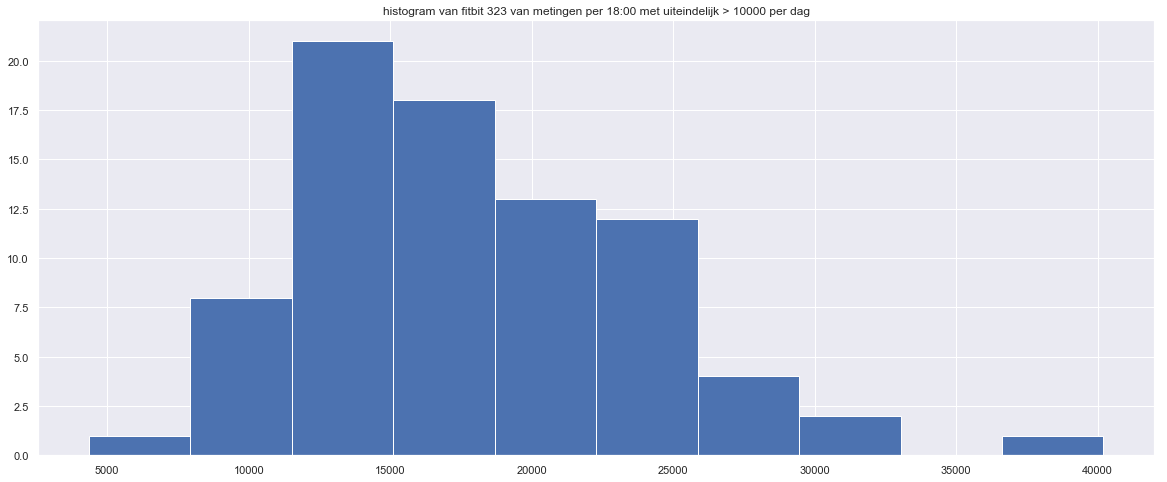

In [240]:
dft = df[(df.uur == date_limit) & (df.fitbit_id == 323.0) & df['class']==1]
plt.figure(figsize=(20,8))
plt.hist(dft['cumsum'])
plt.title('histogram van fitbit 323 van metingen per 18:00 met uiteindelijk > 10000 per dag')
plt.show()

## ?
Group data by fitbit and date

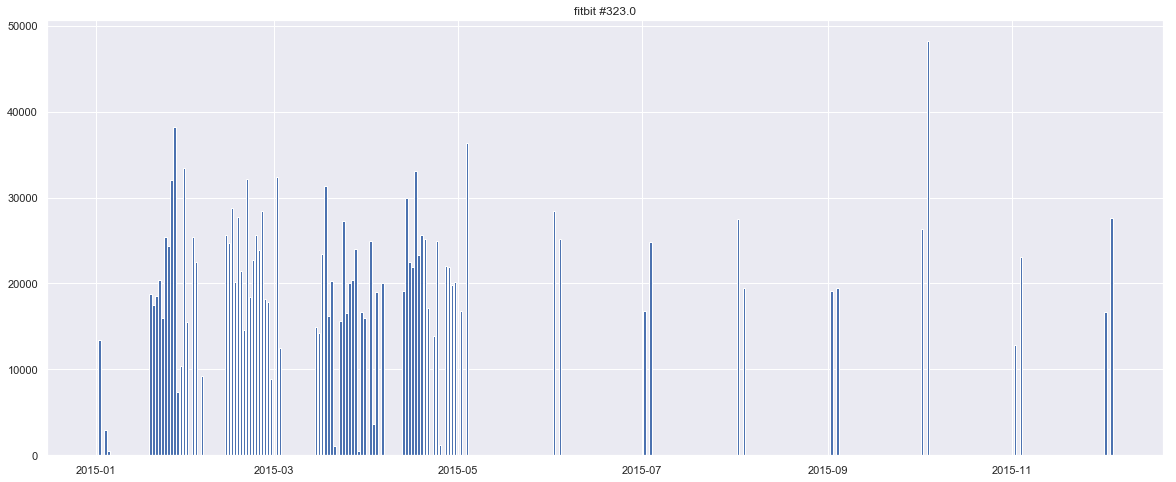

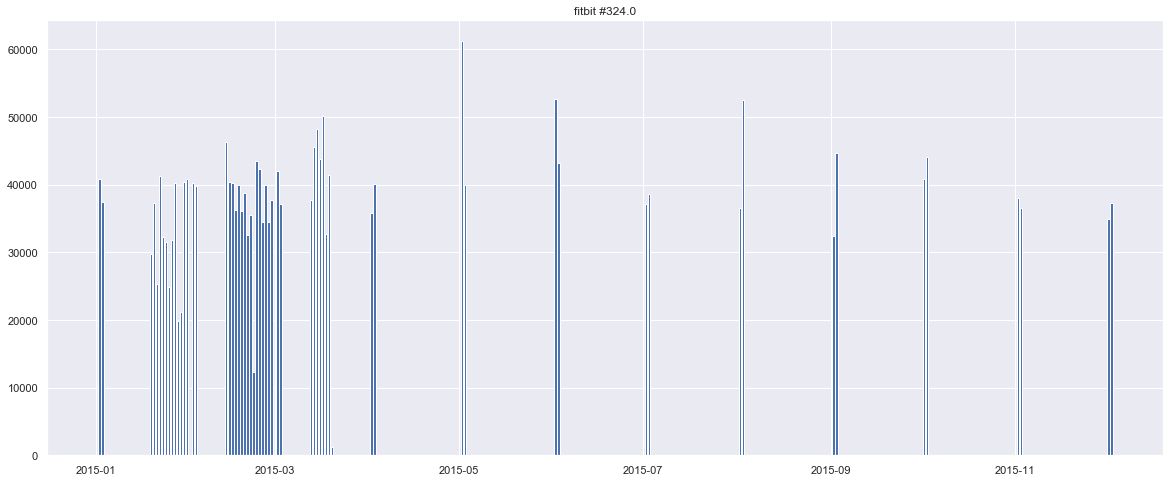

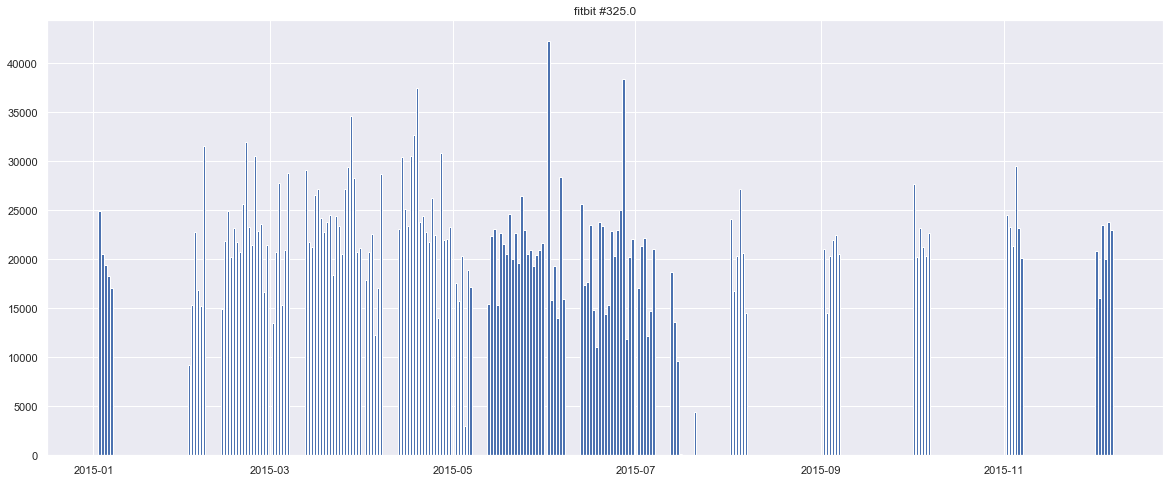

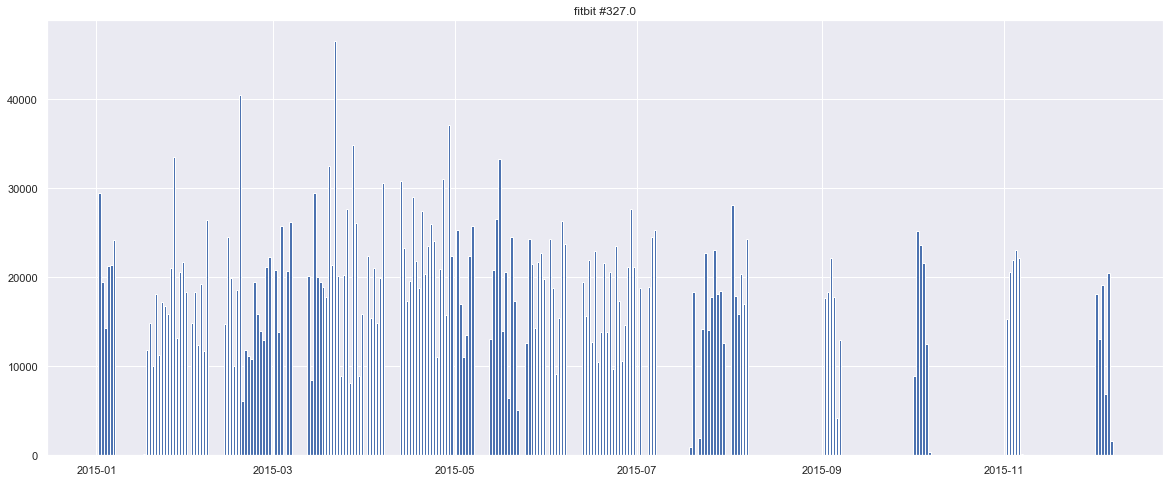

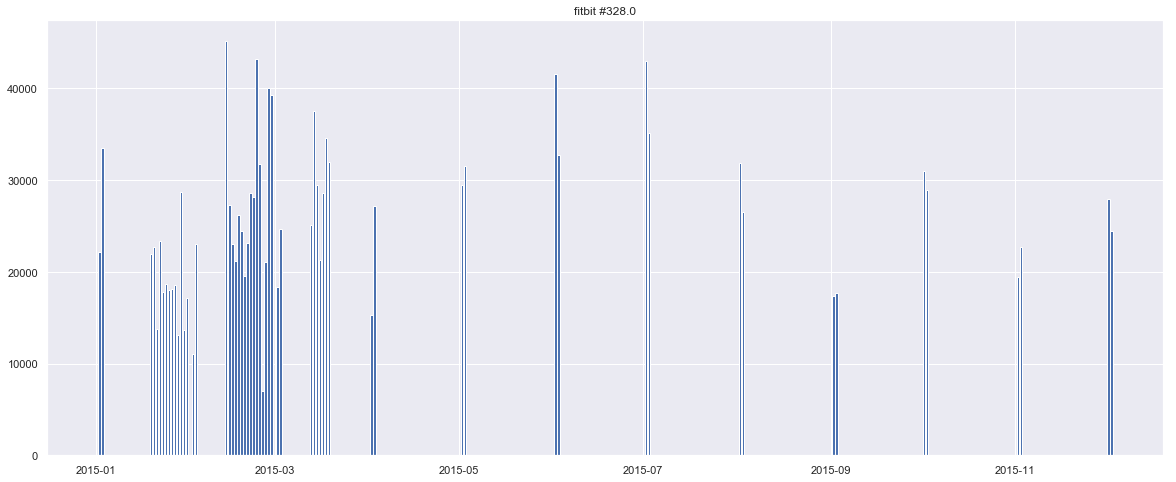

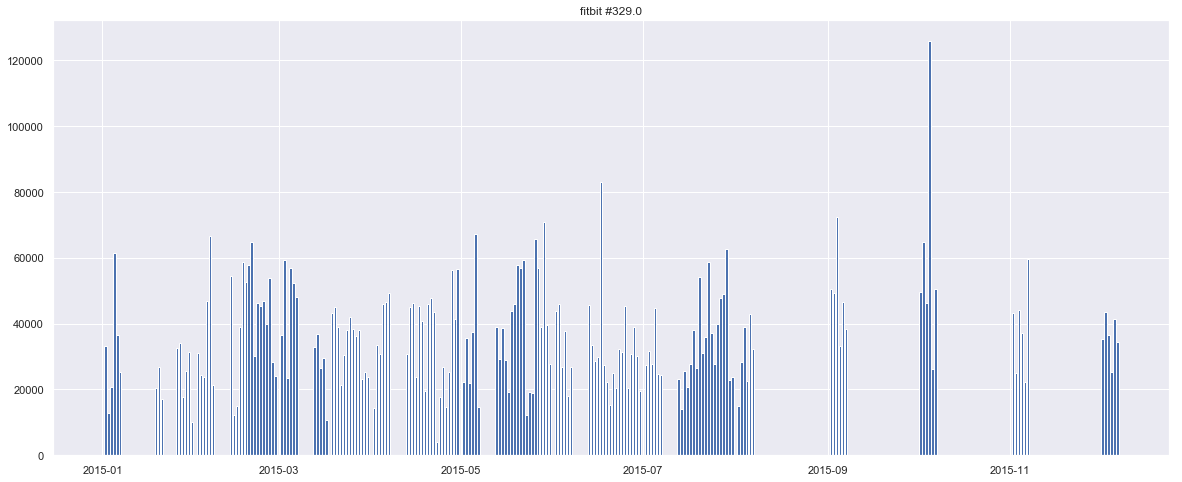

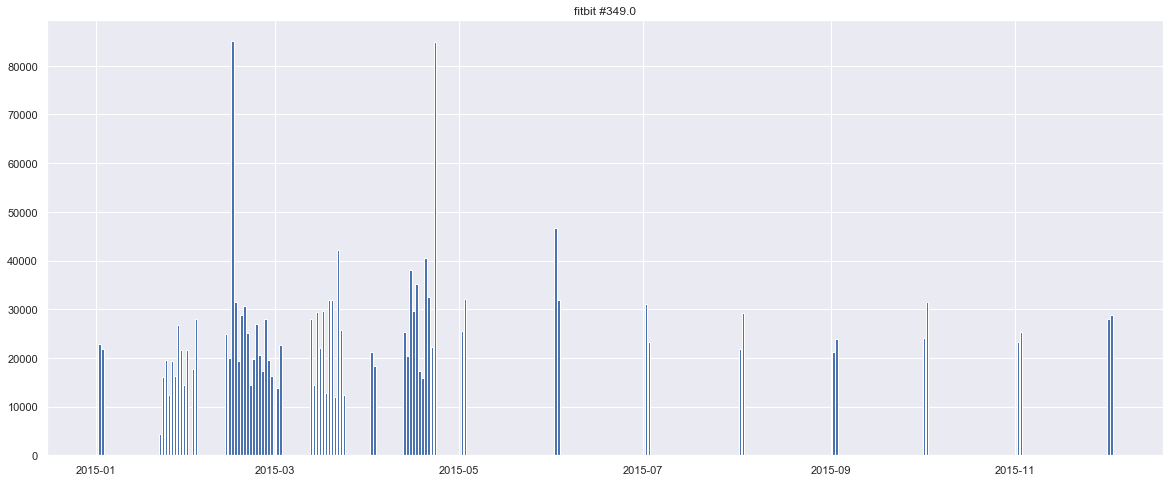

In [210]:
# create aggregate dataframe per fitbit, per date
dfx = df.groupby(['fitbit_id','datum']).sum()
dfx['dag'] = pd.to_datetime(dfx.dag).dt.weekday
dfx.reset_index(inplace=True)

fb_ids = df.fitbit_id.unique().tolist()

for fitbit in fb_ids:
    x = dfx[dfx.fitbit_id == fitbit]['datum'].tolist()
    y = dfx[dfx.fitbit_id == fitbit]['steps'].tolist()

    plt.figure(figsize=(20,8))
    plt.bar(x, y)
    plt.title('fitbit #' + str(fitbit))
    plt.show()

In [ ]:
dfx[dfx.fitbit_id == 323][-100:]

In [ ]:
fb_ids = df.fitbit_id.unique().tolist()

nr_or_rows = math.ceil(float(len(fb_ids) / 3.0))
print(nr_or_rows)                       
fig = plt.figure()
fig, ax = plt.subplots(nr_or_rows, 3, sharey=True, figsize=(20,10))

#plot positions for each entity in list
for nr, entity in enumerate(fb_ids):
    row = math.ceil((nr + 1) / 3) - 1
    column = round(((((nr + 1) / 3)) - row) * 3) -1
    print(row, column)
    df[df.fitbit_id == entity].groupby(['datum']).sum()
    x = df.index
    y = df.steps

    ax[row][column].bar(x,y)
    ax[row][column].set_title(entity)

In [ ]:
# data check
# are there days without steps? (very unlikely)
df_remove = df[(df['cumsum'] == 0) & (df['uur'] == 23)][['datum', 'fitbit_id']]
df_remove['fitbit_id'] = df_remove.fitbit_id.astype(float)
remove = len(df_remove)
print(remove)

df = df[~df.isin(df_remove.to_dict())]
after = len(df)
print(after)
print(before-after)
# df[df['fitbit_id'] != df_remove['fitbit_id']]

# calories vs steps
# df['cal_vs_steps'] = df.calories / df.steps
# plt.hist(df.cal_vs_steps)
# plt.show()
df['dist_vs_steps'] = df.distance / df.steps
plt.hist(df.dist_vs_steps, density=False)
plt.title('distance vs steps')
plt.show()